#### Ido Degani

#  Question 1

### Description:
The file accidents.csv contains data on the number of traffic accidents fatalities and
population of states and territories of the United States. Use PyTorch to estimate the
average number of causalities per 1M citizens in US. Select and justify a model of your
choice. Implement 3 distinct methods: discrete gradient descent, analytic derivation and
PyTorch autograd. You are encouraged to use the code provided in class.

### Imports

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import numpy as np
import torch
import matplotlib
import matplotlib
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import time
import seaborn as sns
import scipy
import pandas as pd
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Define inputs and outputs for the model & Visualize the data


In [2]:
# loading the data and viewing it 
data = pd.read_csv("accidents.csv")
data.head(5)

,Total Population,Traffic fatalities
0,493782,164
1,572059,43
2,608827,98
3,626932,101
4,642200,100


In [3]:
max_population_in_data = data['Total Population'].max()

### Visualize the data

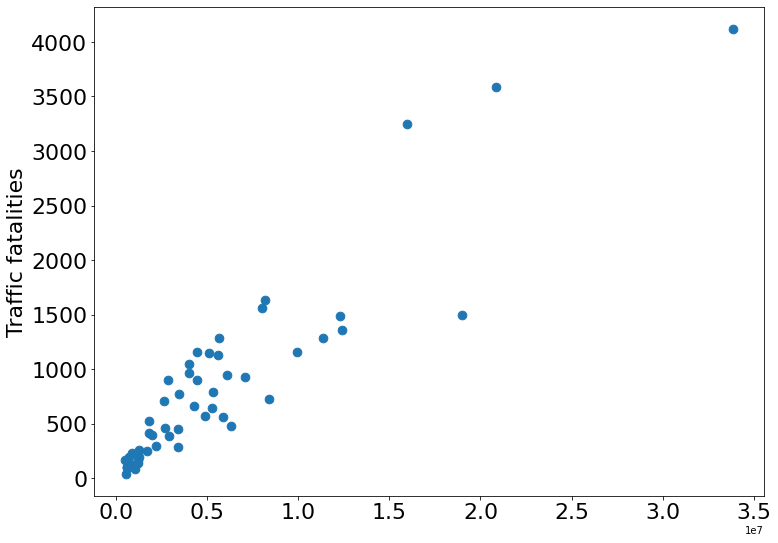

In [4]:
# Intitial Plot of the Data:
fatalities  = data['Traffic fatalities']
total_population = data['Total Population']
plt.figure(figsize=(12,9))
plt.scatter(total_population, fatalities, s=75)
plt.ylabel('Traffic fatalities', fontsize=22)
plt.gca().tick_params(axis='x', labelsize=22)
plt.gca().tick_params(axis='y', labelsize=22)

In [5]:
# Create average number of causalities per 1M
data["average_number_of_causalities_per_1M"] = (data["Traffic fatalities"]/data["Total Population"])*1000000
display(data[0:10])

t_u = torch.tensor(data.iloc[0:,0], dtype=torch.float64)
t_c = torch.tensor(data.iloc[0:,1], dtype=torch.float64)

,Total Population,Traffic fatalities,average_number_of_causalities_per_1M
0,493782,164,332.130373
1,572059,43,75.167072
2,608827,98,160.965266
3,626932,101,161.102001
4,642200,100,155.714731
5,754844,197,260.981077
6,783600,134,171.005615
7,902195,229,253.825393
8,1048319,83,79.174373
9,1211537,142,117.206491


### Note:
Note that:

t_u is the value of the observed X value of which we train the model on.

t_prediction is the value of the model's predictions.

t_c is the 'Y' value of each of the samples we train our model on.

### Visualize the data ( Additional)
Note that:

t_u = set of measurements from the real world 

t_c = true 'Y' values of those the measurements.

W = Weights of our model. We will try the optimize them during the training. 

b = the bias in our model. Kind of free variable in a simple linear equaition.

t_prediction = the value of the model's predictions. Meaning for a sample, it will take make: t_predicion = W * sample + b


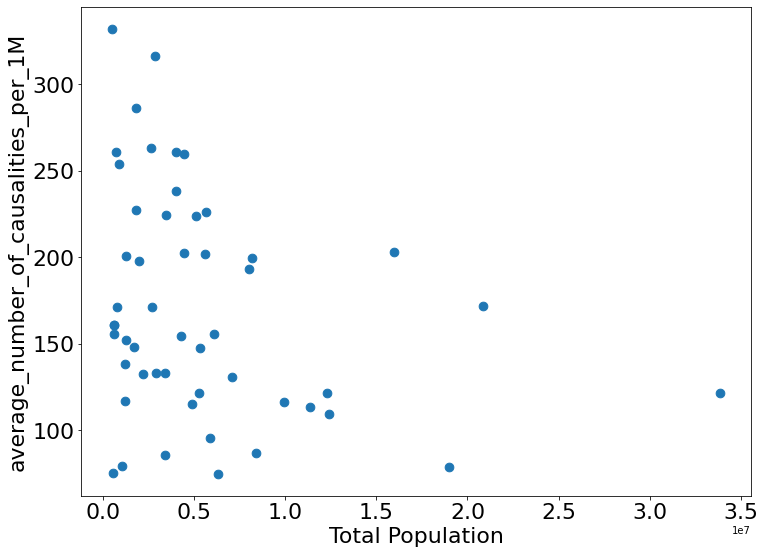

In [6]:
# Intitial Plot of the Data:
average_number_of_causalities_per_1M  = data['average_number_of_causalities_per_1M']
total_population = data['Total Population']
plt.figure(figsize=(12,9))
plt.scatter(total_population, average_number_of_causalities_per_1M, s=75)
plt.xlabel('Total Population', fontsize=22)
plt.ylabel('average_number_of_causalities_per_1M', fontsize=22)
plt.gca().tick_params(axis='x', labelsize=22)
plt.gca().tick_params(axis='y', labelsize=22)

In [7]:
data.head()

,Total Population,Traffic fatalities,average_number_of_causalities_per_1M
0,493782,164,332.130373
1,572059,43,75.167072
2,608827,98,160.965266
3,626932,101,161.102001
4,642200,100,155.714731


In [8]:
populations = data['Total Population']
casualties = data['Traffic fatalities']

populations = torch.tensor(populations).float()
casualties = torch.tensor(casualties).float()

casualties_per_million = (casualties / populations) * 1e6

print(casualties_per_million)


tensor([332.1304,  75.1671, 160.9653, 161.1020, 155.7147, 260.9811, 171.0056,
        253.8254,  79.1744, 117.2065, 138.3735, 152.1660, 200.9346, 148.4284,
        227.2798, 286.4139, 197.6723, 132.5471, 263.3351, 171.4763, 316.3825,
        133.2730,  85.4484, 133.2788, 224.3053, 260.7171, 238.5094, 154.6058,
        259.4950, 202.2835, 115.2561, 224.1439, 121.4012, 147.6600, 201.9584,
        226.3906,  95.5189, 155.7442,  74.9713, 130.6771, 193.4327, 199.5980,
         86.8754, 116.6179, 113.2726, 121.3251, 109.1850, 202.9735,  78.6764,
        171.8315, 121.6357])


### Model Specification
It appears, that there's a linear relationship between the <code>Traffic fatalities</code> and the true value of the <code>Total Population</code><br>

<p style="font-size:30px">Model:</p>
<p style="text-align:center">$\large t_c = \textbf {w} \cdot t_u + \textbf {b}$</p>
<p>
    <table align="left" style="font-size:15px">
        <tr><td>Model parameters</td></tr>
        <tr><td>$\large w -  \textit {weight}$</td></tr>
        <tr><td>$\large b -  \textit {bias}$</td></tr>
    </table>
    
</p>

<p style="font-size:30px">Loss Function:</p>
<p style="text-align:center">$\large L=(t_p - t_c)^{2}$</p>
<p style="text-align:center">$\large L(t_u, t_c)_{w,b}=( [w \cdot t_u + b] - t_c)^{2}$</p>

<p>Objective: find $w$ and $b$ that minimize $L$ for all values $t_u$ and $t_c$</p>

## discrete gradient descent:
- start with initial values of $w$ and $b$
- repeat 
    - compute gradients $dL_{w}(t_u, t_c)$ and $dL_{b}(t_u, t_c)$
    - adjust $w$ and $b$: 
        - $w \Rightarrow w-lr \cdot dL_{w}(t_u, t_c)$ 
        - $b \Rightarrow b-lr \cdot dL_{b}(t_u, t_c)$

In [9]:
def model(t_u, w, b): 
    return w* t_u + b
def loss_fnc(t_u, t_c, w, b):
    return torch.mean(( model(t_u, w,b) -t_c)**2)

In [10]:
w,b = 1, 0 # initialize 
# define gradient descent parameters
delta = 0.001
lr = 0.00001
number_of_iterations = 100000
loss_over_t = torch.zeros( number_of_iterations, dtype=torch.float )

for i in range(number_of_iterations):
    loss_over_t[i] = loss_fnc(t_u, t_c, w,b) # compute loss to monitor progress. 
    dlw = ( loss_fnc(t_u, t_c, w+delta,b) -  loss_fnc(t_u, t_c, w-delta, b)) / (2*delta)
    dlb = ( loss_fnc(t_u, t_c, w,b+delta) -  loss_fnc(t_u, t_c, w, b-delta)) / (2*delta)
    w = w-lr*dlw
    b = b-lr*dlb    

In [11]:
print(f"Results: w={w:0.3f}, b={b:0.3f}")
print(f"Final loss: {loss_over_t[-1]}")
print(f"Mean error: {(model(t_u, w, b)-t_c).mean().abs()}")

Results: w=1832874974993442816.000, b=-110.345
Final loss: inf
Mean error: 1.0113944488673666e+25


### Conclusions from the results:
We can see we got very strange values for w, b and  Final loss. We will try to use Scaling for the X values ( t_u ) on which we 'train' our model on, and see if we get results that makes more sense.

### Performing scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler 
minmax_scaler_x = MinMaxScaler().fit(t_u.reshape(-1,1))
x_minmax_1 = minmax_scaler_x.transform(t_u.reshape(-1,1))
x_minmax = torch.tensor(x_minmax_1, dtype = torch.float64)
t_u_scaled = torch.tensor(x_minmax_1, dtype = torch.float64)

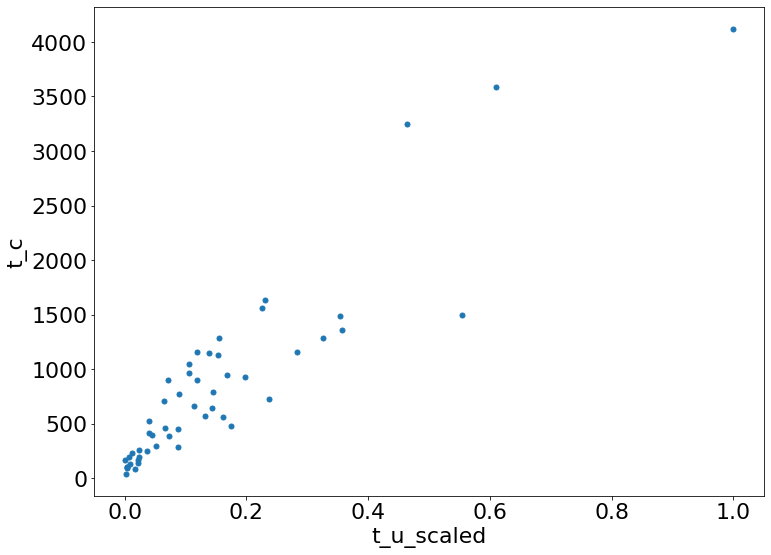

In [13]:
plt.figure(figsize=(12,9))
plt.scatter(t_u_scaled, t_c, s=25)
plt.xlabel('t_u_scaled', fontsize=22)
plt.ylabel('t_c', fontsize=22)
plt.gca().tick_params(axis='x', labelsize=22)
plt.gca().tick_params(axis='y', labelsize=22)

In [14]:
t_c_list = t_c.tolist()
t_u_scaled_list = t_u_scaled.tolist()

In [15]:
max(t_c_list)

4120.0

In [16]:
max(t_u_scaled_list)

[1.0]

In [18]:
t_u_list = t_u.tolist()
max_value_of_t_u_list_33_87 = max(t_u_list)/1000000
max_value_of_t_u_list_33_87

33.871648

In [19]:
t_u_scaled[0:10]

tensor([[0.0000],
        [0.0023],
        [0.0034],
        [0.0040],
        [0.0044],
        [0.0078],
        [0.0087],
        [0.0122],
        [0.0166],
        [0.0215]], dtype=torch.float64)

In [20]:
w,b = 1, 0 # initialize 
# define gradient descent parameters
delta = 0.001
lr = 0.0001
number_of_iterations = 1000
loss_over_t = torch.zeros( number_of_iterations, dtype=torch.float )

iteration = []
w_value = []

for i in range(number_of_iterations):
    loss_over_t[i] = loss_fnc(t_u_scaled, t_c, w,b) # compute loss to monitor progress. 
    # compute gradients
    dlw = ( loss_fnc(t_u_scaled, t_c, w+delta,b) -  loss_fnc(t_u_scaled, t_c, w-delta, b)) / (2*delta)
    dlb = ( loss_fnc(t_u_scaled, t_c, w,b+delta) -  loss_fnc(t_u_scaled, t_c, w, b-delta)) / (2*delta)
    if(i % 100 == 0):
        iteration.append(i)
        w_value.append(w-lr*dlw)
    # update parameter values
    w = w-lr*dlw
    b = b-lr*dlb    

In [21]:
print(f"Results: w={w:0.3f}, b={b:0.3f}")
print(f"Final loss: {loss_over_t[-1]}")
print(f"Mean error: {(model(t_u, w, b)-t_c).mean().abs()}")

Results: w=23.674, b=151.197
Final loss: 1165795.125
Mean error: 130635765.16238002


### Estiamte average number of causalities per 1M citizens in US

In [22]:
# finding 1 million in the new scale we made:
one_mllion_new = 1/max_value_of_t_u_list_33_87
model(one_mllion_new,w,b)

tensor(151.8962, dtype=torch.float64)

In [23]:
data.columns

Index(['Total Population', 'Traffic fatalities',
       'average_number_of_causalities_per_1M'],
      dtype='object')

In [24]:

mask = (data["Total Population"] >= 900000) & (data["Total Population"] <= 1500000)

# Use the mask to select the relevant rows
filtered_df = data[mask]

# Print only the relevant columns
print(filtered_df)


    Total Population  Traffic fatalities  average_number_of_causalities_per_1M
7             902195                 229                            253.825393
8            1048319                  83                             79.174373
9            1211537                 142                            117.206491
10           1235786                 171                            138.373472
11           1274923                 194                            152.166052
12           1293953                 260                            200.934655


### conclusion: as we can see our model stimation for 1M people is 151.8 causalities. Which is that close to reality from what wev'e seen from the graph. We had a few observations withthe following values:

0.9M citizens with 229 causalities 

1.04M citizens with 83 causalities 

1.2M citizens with 142 causalities 



Meaning our model is being able to predict closley to what reality is. 

### Display convergence

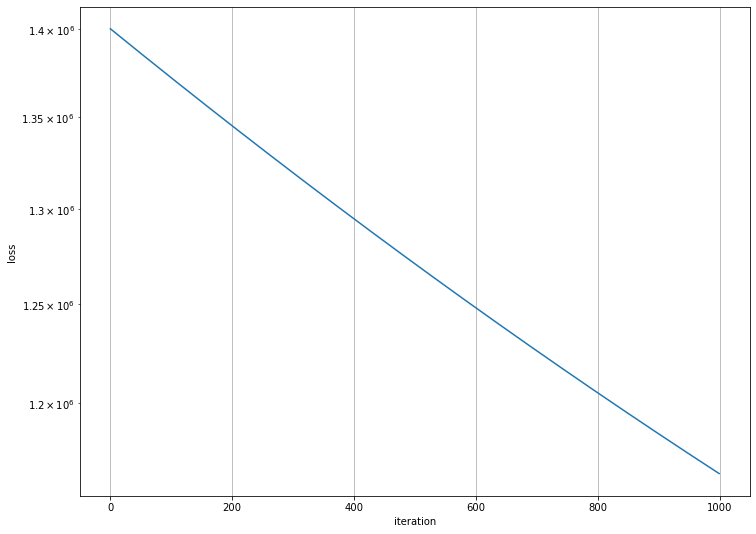

In [25]:
fig, ax = plt.subplots(figsize=(12,9))
ax.semilogy( range(len(loss_over_t)), loss_over_t)

plt.grid()
ax.set_ylabel('loss'); ax.set_xlabel('iteration');

### Demonstrate the rate of change of the loss function
plot $Loss_{t+1}-Loss_{t}$ over time

Text(0.5, 1.0, 'Change of loss over iterations')

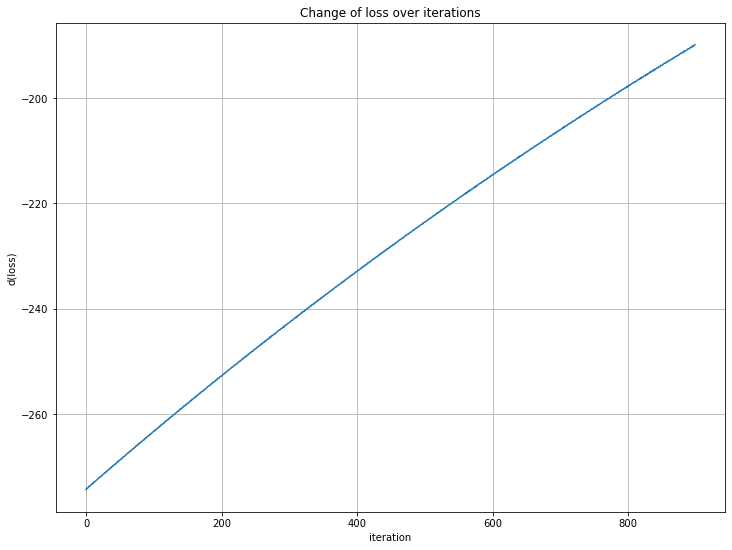

In [26]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot( range(len(loss_over_t)-101), np.diff(loss_over_t[100:]))

plt.grid()
ax.set_ylabel('d(loss)'); ax.set_xlabel('iteration');
ax.set_title('Change of loss over iterations')

## analytic derivation

In [27]:
def model(t_u, w, b):
    return t_u*w + b

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1

In [28]:
def loss_fn(t_p, t_c):
    return torch.mean(torch.square(t_p-t_c))

def dloss_fn_dm(t_p, t_c):
    return (2*(t_p-t_c)) / t_p.shape[0] # 1/N is from the mean. 

In [29]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dm = dloss_fn_dm(t_p, t_c)
    dloss_dw = dloss_dm * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dm * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [30]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b) # forward pass: compute the model prediction
        loss = loss_fn(t_p, t_c) # computre the loss (to monitor conversion)
        grad = grad_fn(t_u, t_c, t_p, w, b) #  backward pass: use local loss gradient to
                                            # compute how loss responds to parameter changes
        params = params - learning_rate * grad # update parameters
        if epoch % 10 ==0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

### Run the model

In [ ]:
training_loop(
        n_epochs = 100, 
        learning_rate = 1e-5,
        params = torch.tensor([1.0, 0.0]), # (w_0, b_0)
        t_u = t_u,
        t_c = t_c)
# y_true = t_c
# x_t = t_u 
# x = t_u_scaled

### Plot convergence

In [33]:
def training_loop(n_epochs, learning_rate, params, x, y_true):
    """
    Perform training on a model with a single input and output.
    
    Arguments:
    n_epochs -- The number of training epochs to run. This is the number of times the model will see the entire training dataset.
    learning_rate -- The learning rate for the optimizer. This determines the step size for adjusting the model's parameters during training.
    params -- A tuple of the model's parameters. In this case, it appears to be a tuple of the weights and biases of the model.
    x -- The input data for the model.
    y_true -- The true labels for the input data.
    
    Returns:
    params -- The final model parameters after training.
    log -- A stack of tensors containing the epoch number, loss, and model parameters at each epoch.
    
    """
    log = []
    for epoch in range(1, n_epochs + 1):
        # Unpack the model parameters
        w, b = params
        
        # Make a prediction on the input data using the model's parameters
        y_pred = model(x, w, b) 
        
        # Calculate the loss by comparing the model's prediction to the true labels
        loss = loss_fn(y_pred, y_true) 
        
        # Calculate the gradients of the loss with respect to the model's parameters
        grad = grad_fn(x, y_true, y_pred, w, b) 
        
        # Adjust the model's parameters by subtracting the learning rate multiplied by the gradients from the original parameters
        params = params - learning_rate * grad
        
        # Append the current epoch number, loss, and model parameters to the log
        log.append(torch.tensor([epoch, loss, params[0], params[1], grad[0], grad[1] ]))

        # If the current epoch is a multiple of 10, print the epoch number and loss
        if epoch % 10 ==0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    
    # Return the final model parameters and the log as a stack of tensors
    return params, torch.stack(log)

In [ ]:
params, log = training_loop(
        n_epochs = 100, 
        learning_rate = 1e-2,
        params = torch.tensor([1.0, 0.0]), # (w_0, b_0)
        x = x_minmax,
        y_true = y_true)
params_analytic_derivation = params.clone().detach()
total_loss_analytic_derivation = log[-1][1]

In [35]:
log2 = log.clone().detach()

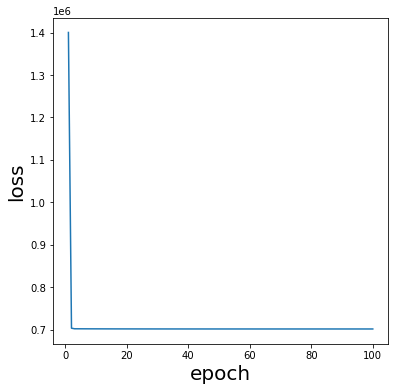

In [36]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(log[:,0], log[:,1])
ax.set_xlabel('epoch', fontsize=20);
ax.set_ylabel('loss', fontsize=20);

In [37]:
print(f"Results: w={w:0.3f}, b={b:0.3f}")
print(f"Final loss: {loss_over_t[-1]}")
print(f"Mean error: {(model(t_u, w, b)-t_c).mean().abs()}")

Results: w=23.674, b=151.197
Final loss: 1165795.125
Mean error: 130635765.16238002


### As we can see both the discrete gradient descent and the analytic derivation model gave us the exact same weights,
### meaning we will get the same results/

### prediction: 

In [38]:
# finding 1 million in the new scale we made:
one_mllion_new = 1/max_value_of_t_u_list_33_87
model(one_mllion_new,w,b)

tensor(151.8962, dtype=torch.float64)

## PyTorch autograd:
Use PyTorch autograd mechanism to compute gradient derivatives automatically.

In [42]:
def model(x, w, b): 
    return w*x + b
def loss_fn(y_pred, y_true): 
    return torch.mean(torch.square(y_pred-y_true))

In [43]:
def training_loop(n_epochs, learning_rate, params, x, y_true):
    log = []
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y_true)
        log.append(torch.tensor([epoch, loss, params[0], params[1]])) # epoch, loss, w, b, grad_w, grad_b

        if params.grad is not None:         
            params.grad.zero_() # zero gradients before computing them again. 
        loss.backward() # compute gradients
        

        with torch.no_grad(): # do not store the following in the computation graph!
            params -= learning_rate * params.grad # use computed gradients to update parameter values. 

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params, log

In [44]:
params, log = training_loop(
    n_epochs = 10000,
    learning_rate = 1e-5,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    x = x_minmax, # normalize variables. 
    y_true = y_true)

print("---------------------------------------------")
print(f"w={params[0]:3.3f}, b={params[1]:3.3f}")
params_autograd = params.clone().detach()
total_loss_autograd = log[-1][1]

Epoch 500, Loss 1386027.877422
Epoch 1000, Loss 1372169.649960
Epoch 1500, Loss 1358592.194998
Epoch 2000, Loss 1345289.822577
Epoch 2500, Loss 1332256.952134
Epoch 3000, Loss 1319488.128913
Epoch 3500, Loss 1306978.001847
Epoch 4000, Loss 1294721.333879
Epoch 4500, Loss 1282712.949810
Epoch 5000, Loss 1270947.920728
Epoch 5500, Loss 1259421.234354
Epoch 6000, Loss 1248128.085375
Epoch 6500, Loss 1237063.708498
Epoch 7000, Loss 1226223.544678
Epoch 7500, Loss 1215602.916443
Epoch 8000, Loss 1205197.472026
Epoch 8500, Loss 1195002.906694
Epoch 9000, Loss 1185014.776006
Epoch 9500, Loss 1175229.176638
Epoch 10000, Loss 1165641.768629
---------------------------------------------
w=23.672, b=151.185


In [45]:
# finding 1 million in the new scale we made:
one_mllion_new = 1/max_value_of_t_u_list_33_87
model(one_mllion_new,w,b)

tensor(151.8962, dtype=torch.float64)

### As we can all three models had the exact same estimation which is 151.8 causalities

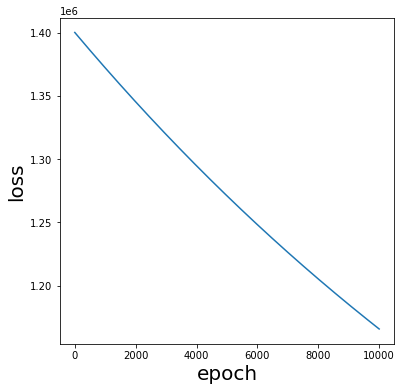

In [47]:
epochs = []
loss_list = []
for epoch in log:
    epochs.append(epoch[0].numpy())
    loss_list.append(epoch[1].numpy())
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(epochs, loss_list)
ax.set_xlabel('epoch', fontsize=20);
ax.set_ylabel('loss', fontsize=20);

We can see above that the more epochs we have the less the lost, which means we can try to increase the number of epochs so the loss of our model will be smaller. ( I've tried but it took hours )

### Selecting a model of my choice:

For this specific problem, all three models provided nearly identical estimations and loss values. Furthermore, there was little difference in the training and running times of the models. As a result, I selected all three models for the task because, given the small dataset and single variable we trained on, there appears to be no significant difference between them.

It is worth noting that, in practice, we may see a faster convergence of the graph or a steeper slope of decrease. However, when I increased the delta value in the models above, the results were not realistic - the estimate for the number of casualties among one million citizens was unreasonably high, so I decided to keep the delta value lower to avoid such discrepancies.

# Question 2 

In [39]:
# read the data 
from sklearn.model_selection import train_test_split

df_clusters = pd.read_csv("clusters.zip")
df_clusters[0:5]

X = df_clusters.drop(labels=[' data'], axis = 1)
y = df_clusters.iloc[:, 2]

#Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,shuffle = False, random_state = 23)
print("number of train samples: ", y_train.shape[0])
print("number of test samples: ", y_test.shape[0])

number of train samples:  900000
number of test samples:  100000


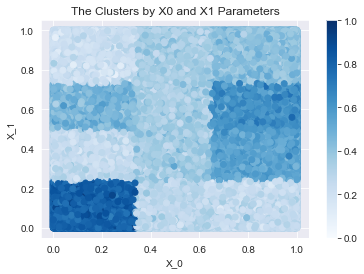

In [40]:
# plot the data:
plt.scatter(X["x_0"].tolist(), X[" x_1"].tolist(),c=y,cmap="Blues")
plt.title("The Clusters by X0 and X1 Parameters")
plt.xlabel("X_0")
plt.ylabel("X_1")
plt.colorbar()
plt.show()

In [41]:
from sklearn.preprocessing import StandardScaler

scaler_x =  StandardScaler()
scaler_x.fit(x_train)
x_train_normalized = scaler_x.transform(x_train)

x_test_normalized = scaler_x.transform(x_test)

In [42]:
y_train_t = torch.tensor(y_train.values)
y_test_t = torch.tensor(y_test.values)

x_train_normalized_t = torch.tensor(x_train_normalized)
x_test_normalized_t = torch.tensor(x_test_normalized)

In [43]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, 20) 
        self.relu1 = torch.nn.ReLU() 
        
        self.fc2 = torch.nn.Linear(20,30)
        self.relu2 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(30,40)
        self.relu3 = torch.nn.ReLU()
        
        self.fc4 = torch.nn.Linear(40,1)

        
    def forward(self,x):        
        x = x.view(-1,2) 
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x)) 
        x = self.relu3(self.fc3(x)) 
        x = self.fc4(x) 
        return x

### Instantiate the model

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device=device) # Net.__init__()

### Define Loss function and optimizer

In [45]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.05)

### Training Loop IDPD


In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [47]:
n_epochs = 50
batch_size = 100

x_train_normalized_t = x_train_normalized_t.to(device=device).to(dtype=torch.float32)
y_train_t = y_train_t.to(device=device).to(dtype=torch.float32)

model.train() # set model into train mode. 

for epoch in range(n_epochs):
    current_loss = 0
    train_indeces = torch.randperm( (len(x_train_normalized_t)//batch_size)*batch_size ).to(device=device) #  len(train_indeces) is an integer number of batches. 
    train_indeces = train_indeces.view(-1, batch_size) # shape: # batches x batch size

    for current_batch_indeces in train_indeces:
        train_data = x_train_normalized_t[current_batch_indeces].to(dtype=torch.float32)
        train_data_labels = y_train_t[current_batch_indeces].to(dtype=torch.float32).reshape(-1,1)

        optimizer.zero_grad() 
        y_pred = model(train_data) 
        loss = criterion(y_pred, train_data_labels)
        loss.backward() 
        optimizer.step()  

        current_loss += loss.item() * len(train_data) 
    with torch.no_grad(): 
        mse_train = mean_squared_error(y_train_t, model(x_train_normalized_t))
        r_2_train = r2_score(train_data_labels.detach().numpy(), y_pred.detach().numpy())
            
        if (epoch % 10 == 0 or epoch in [1,2,3,4,5,6,7,8,9, n_epochs]):
            print(epoch, "of", n_epochs, " | Loss:", round(current_loss /len(x_train_normalized_t),4),
                  "| MSE train:", round(mse_train,4), "| R^2 train:", round(r_2_train,4))
model.eval()

0 of 50  | Loss: 0.0098 | MSE train: 0.0064 | R^2 train: 0.7715
1 of 50  | Loss: 0.0055 | MSE train: 0.0049 | R^2 train: 0.8955
2 of 50  | Loss: 0.0047 | MSE train: 0.0043 | R^2 train: 0.8654
3 of 50  | Loss: 0.0044 | MSE train: 0.0042 | R^2 train: 0.7872
4 of 50  | Loss: 0.0043 | MSE train: 0.0042 | R^2 train: 0.8308
5 of 50  | Loss: 0.0041 | MSE train: 0.004 | R^2 train: 0.8649
6 of 50  | Loss: 0.004 | MSE train: 0.0059 | R^2 train: 0.8445
7 of 50  | Loss: 0.0038 | MSE train: 0.0035 | R^2 train: 0.8209
8 of 50  | Loss: 0.0038 | MSE train: 0.0035 | R^2 train: 0.8839
9 of 50  | Loss: 0.0037 | MSE train: 0.0034 | R^2 train: 0.8774
10 of 50  | Loss: 0.0036 | MSE train: 0.0039 | R^2 train: 0.8796
20 of 50  | Loss: 0.0033 | MSE train: 0.0031 | R^2 train: 0.8995
30 of 50  | Loss: 0.0031 | MSE train: 0.0029 | R^2 train: 0.9134
40 of 50  | Loss: 0.003 | MSE train: 0.0029 | R^2 train: 0.94


Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=20, out_features=30, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=30, out_features=40, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=40, out_features=1, bias=True)
)

In [48]:
y_pred_test = model(x_test_normalized_t.to(dtype=torch.float32))
y_pred_test = y_pred_test.detach().numpy()

mse_test = mean_squared_error(y_test, y_pred_test)
r_2_test = r2_score(y_test, y_pred_test)

print(f" MSE test set: {mse_test:0.4f}")
print(f" R^2 test set: {r_2_test:0.4f}")

 MSE test set: 0.0029
 R^2 test set: 0.9038


In [49]:
test_max_x = model(x_test_normalized_t.to(device).to(dtype=torch.float32))  

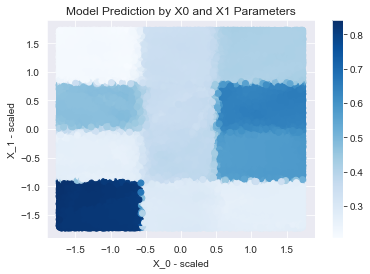

In [50]:
t_r = test_max_x.tolist()
plt.scatter(x_test_normalized[:,0], x_test_normalized[:,1],c=t_r,cmap="Blues")
plt.title("Model Prediction by X0 and X1 Parameters")
plt.xlabel("X_0 - scaled")
plt.ylabel("X_1 - scaled")
plt.colorbar()
plt.show()

# Question 3

Zalando is a multinational e-commerce platform selling fashion goods in many European countries.

It released a Fashion MNIST dataset – a set of (60,000 train + 10,000 test, stored in fashion-mnist_train.zip and fashion-mnist_test.zip) images of 10 types of clothes.

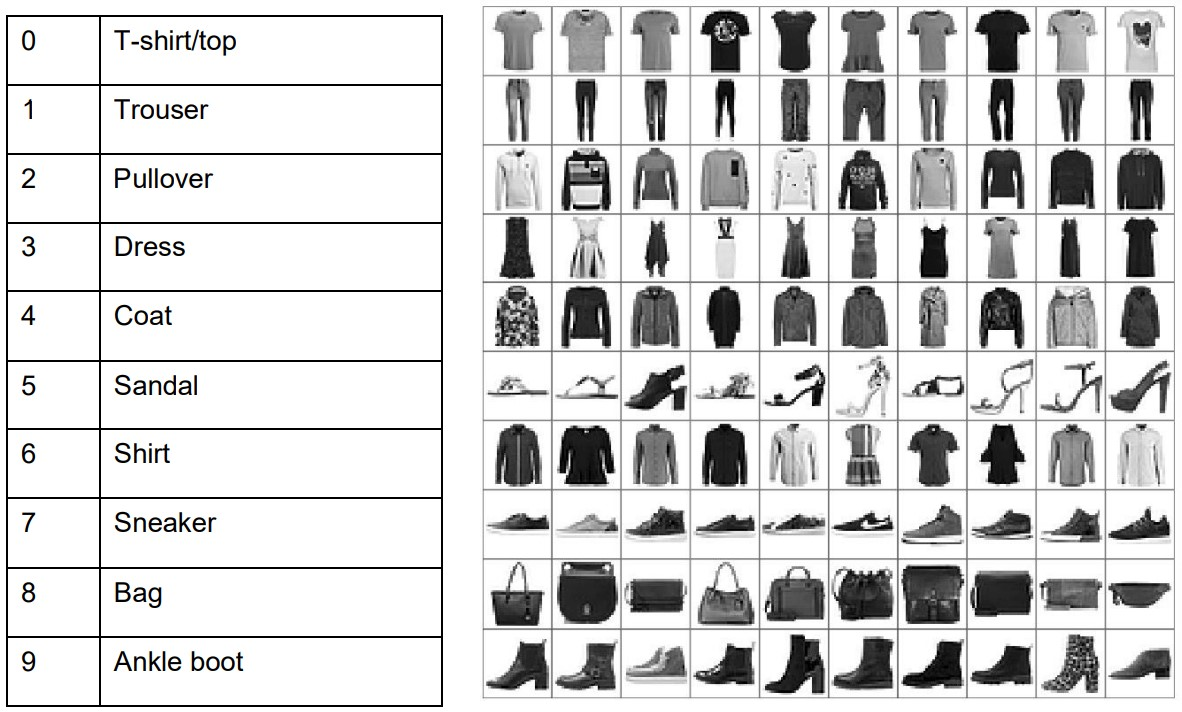

## a. Train fully connected neural network with few hidden layers to classify images in Fashion MNIST dataset.

#### Let's Break-down the steps of this section:
1. Read the data & split it into Train,Validation, Test.
2. Normalize our data 
3. Decide how our neural network model will look like ( how many layers, amout of perceptrons )
4. Intitate the model & Define loss function & model accuracy 
5. Define training function
6. test on the test data set

### Reading the Data ( Train set )

In [7]:
train_fashion = pd.read_csv("fashion-mnist_train.csv")
X_train_fashion = train_fashion.drop(labels=["label"],axis=1)
X_train_fashion_t = torch.tensor(X_train_fashion.values, dtype = torch.uint8)
Y_train_fashion = train_fashion.iloc[0:, 0]
Y_train_fashion_t = torch.tensor(Y_train_fashion.values, dtype = torch.uint8)

#### Splitting the Data

In [8]:
x_train_t, x_validation_t, y_train_t, y_validation_t = train_test_split(X_train_fashion_t, Y_train_fashion_t, test_size = 0.1,shuffle = False, random_state = 1998)

#### Reading the Data ( Train set )

In [9]:
test_fashion = pd.read_csv("fashion-mnist_test.csv")
x_test_fashion = test_fashion.drop(labels=["label"],axis=1)
x_test_fashion_t = torch.tensor(x_test_fashion.values, dtype = torch.uint8)
y_test_fashion = test_fashion.iloc[0:, 0]
y_test_fashion_t = torch.tensor(y_test_fashion.values, dtype = torch.uint8)

### Normalize our data 

In [10]:
x_train_t_normalize = x_train_t.to(dtype = torch.float32)/254
x_validation_t_normalize = x_validation_t.to(dtype = torch.float32)/254
x_test_fashion_t_normalize = x_test_fashion_t.to(dtype = torch.float32)/254

### Decide how our neural network model will look like (how many layers, amout of perceptrons)

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 512) 
        self.relu1 = torch.nn.ReLU() 
        
        self.fc2 = torch.nn.Linear(512,256) 
        self.relu2 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(256,10)
        self.softmax3 = torch.nn.LogSoftmax(dim=1) 
    def forward(self,x):        
        x = x.view(-1,28*28) 
        x = self.relu1(self.fc1(x)) 
        x = self.relu2(self.fc2(x))
        x = self.softmax3(self.fc3(x))
        return x

### Intitate the model & Define loss function & model accuracy 

In [12]:
model = Net().to(device=device)

In [13]:
criterion = torch.nn.CrossEntropyLoss() #The loss function
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01) #The optimizer

In [14]:
def model_accuracy(model, x_data, y_data):
    """
    Calculate the accuracy of the model on the given input data.
    
    Parameters:
    - model: a PyTorch model
    - x_data: a PyTorch tensor of shape (batch_size, num_features) representing the input data
    - y_data: a PyTorch tensor of shape (batch_size,) representing the true labels for the input data
    
    Returns:
    - accuracy: a float representing the accuracy of the model, between 0 and 1.
    """
    device = next(model.parameters()).device 
    model.eval() 
    with torch.no_grad():
        x_data, y_data = x_data.to(device=device), y_data.to(device=device)
        
        _, max_index = model(x_data).max(dim=1)
        
        max_index = max_index.to(dtype=torch.float32, device=torch.device("cpu"))
        y_data = y_data.to(dtype=torch.float32, device=torch.device("cpu"))
        
        number_of_matches = (max_index == y_data).sum()
        
        return number_of_matches / len(y_data)

### Define training function

In [21]:
def train_Net(model, x_train_normalize_t, y_train_t, criterion, optimizer,
                         x_validation_normalize_t=None, y_validation_t=None,
                         n_epochs=50, batch_size=500, device="cpu"):
    """
    Train a PyTorch model on image data.
    
    Parameters:
    - model: a PyTorch model
    - x_train_normalize_t: a PyTorch tensor of shape (batch_size, num_features) representing the training data
    - y_train_t: a PyTorch tensor of shape (batch_size,) representing the true labels for the training data
    - criterion: a PyTorch loss function
    - optimizer: a PyTorch optimizer
    - x_validation_normalize_t (optional): a PyTorch tensor of shape (batch_size, num_features) representing the validation data
    - y_validation_t (optional): a PyTorch tensor of shape (batch_size,) representing the true labels for the validation data
    - n_epochs: number of epochs to train for (default 50)
    - batch_size: the size of each batch (default 500)
    - device: the device to use for training (default "cpu")
    
    Returns:
    - progress_log: a list of dictionaries containing the following keys:
        - 'epoch': the epoch number
        - 'loss': the training loss for the epoch
        - 'train epoch time': the time taken to train the epoch in seconds
        - 'train_accuracy': the accuracy of the model on the training data for the epoch
        - 'validate_accuracy': the accuracy of the model on the validation data for the epoch (None if no validation data provided)
    """
    train_images_norm = x_train_normalize_t.to(device=device)
    train_labels = y_train_t.to(device=device)
    if x_validation_normalize_t is None or y_validation_t is None:
        validation_set_checker = False
    else:
        validation_images = x_validation_normalize_t.to(device=device)
        validation_labels = y_validation_t.to(device=device)
        validation_set_checker = True
    training_time_epochs = []
    progress_log = []
    
    model.to(device)
    
    for epoch in range(n_epochs):
        model.train() 
        
        current_loss = 0
        train_indeces = torch.randperm((len(train_images_norm)//batch_size)*batch_size).to(device=device) #  len(train_indeces) is an integer number of batches
        train_indeces = train_indeces.view(-1, batch_size) 
        
        training_time_batches = []
        for current_batch_indeces in train_indeces: 
            train_data = train_images_norm[current_batch_indeces].to(dtype=torch.float32)
            train_data_labels = train_labels[current_batch_indeces].to(dtype=torch.int64)

            optimizer.zero_grad() 
            
            start_train_time = time.time() 
            output = model(train_data) 
            batch_train_time = time.time() - start_train_time 
            training_time_batches.append(batch_train_time)
            
            loss = criterion(output, train_data_labels) 
            loss.backward()
            optimizer.step()

            current_loss += loss.item() * len(train_data)
            
        training_time_epochs.append(np.mean(training_time_batches))
        
        with torch.no_grad():
            train_accuracy = model_accuracy(model, train_data, train_data_labels)
            if validation_set_checker:
                validate_accuracy = model_accuracy(model, validation_images, validation_labels)
            else:
                validate_accuracy = None           
            progress_log.append({'epoch': epoch,
                                 'loss': current_loss/len(train_images_norm),
                                 'train epoch time': training_time_epochs[epoch],
                                 'train_accuracy': train_accuracy, 'validate_accuracy': validate_accuracy})
            
    return model, progress_log



In [22]:
model = Net().to(device=device)
criterion = torch.nn.CrossEntropyLoss() #The loss function
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01) #The optimizer

n_epochs = 25
batch_size = 400

model_new, progress_log = train_Net(model = model,
                                 x_train_normalize_t = x_train_t_normalize , y_train_t = y_train_t,
                                 x_validation_normalize_t = x_validation_t_normalize, y_validation_t = y_validation_t,
                                 criterion = criterion, optimizer = optimizer,
                                 n_epochs = n_epochs, batch_size = batch_size, device = device)
    

## 3. b

In [23]:
parameters_for_layers = [[20,30], [70, 75], [150,200] ,[250,128],[350, 250], 
                         [20,30, 50], [70, 75, 100], [150,200, 150] ,[250,128, 200], 
                         [20,30, 50, 75], [150,200,150,250], 
                        [20,30,50,75, 100], [150,200,150,250,300],
                        [300,250,100,250,300,100]] 

In [37]:
class net_playing_models_different_params(torch.nn.Module): # derive your model from the basic torch.nn.Model
    """
    A neural network model class derived from torch.nn.Module.
    
    Parameters:
    -----------
    input_layer : list
        A list with a single element representing the size of the input layer.
        Default value is [28*28], which corresponds to the size of a 28 x 28 image.
    layers : list
        A list representing the sizes of the hidden layers of the neural network.
        Default value is [512, 256], which means the model will have two hidden layers
        with 512 and 256 units respectively.
    output_layer : list
        A list with a single element representing the size of the output layer.
        Default value is [10], which corresponds to the number of classes in the
        classification task.
    drop_out : bool
        A boolean value indicating whether to use dropout regularization in the model.
        Default value is False.
    batch_norm : bool
        A boolean value indicating whether to use batch normalization in the model.
        Default value is False.
    
    Attributes:
    -----------
    flatten : torch.nn.Module
        A module used to flatten the input tensor.
    input_layer : int
        Size of the input layer.
    layers_stack : torch.nn.Sequential
        A module holding the different layers of the model.
    layers : list
        A list containing the individual layers of the model.
        
    Methods:
    --------
    forward(x)
        Computes the output logits of the model given an input tensor.
    """
    
    def __init__(self, input_layer = [28*28], layers=[512, 256], output_layer = [10], drop_out=False,
                batch_norm = False):
        super(net_playing_models_different_params,self).__init__()
        self.flatten = torch.nn.Flatten()
        self.input_layer = input_layer[0]
        layers = input_layer + layers + output_layer     
        
        layers_list = []
        for Layer_i in range(1, len(layers)): 
            layers_list.append(torch.nn.Linear(layers[Layer_i-1], layers[Layer_i]) )
            if Layer_i < len(layers)-1:
                layers_list.append( torch.nn.ReLU() )
                if drop_out:
                    layers_list.append(torch.nn.Dropout(drop_out))
                if batch_norm:
                    layers_list.append(torch.nn.BatchNorm1d(layers[Layer_i]))


        layers_list.append( torch.nn.LogSoftmax())
        
        self.layers_stack = torch.nn.Sequential(*layers_list)
        self.layers = layers_list 
        
    def forward(self,x):        
        x = x.view(-1,self.input_layer) 
        logits = self.layers_stack(x)
        
        return logits
drop_out = 0.33
batch_norm = True

n_epochs = 30
batch_size = 500

lr_optimizer = 0.4
momentum_optimizer = 0.75
start_time = time.time()
num_layers_vec = [len(i) for i in parameters_for_layers]

models = []
total_params_list=[]
train_times_models = []
progress_log_list = []
m = 0
for layers in parameters_for_layers:
    m+=1
    
    model1 = net_playing_models_different_params(input_layer = [28*28],
                        layers = layers,
                        output_layer = [10],
                        drop_out = drop_out,
                        batch_norm = batch_norm).to(device=device)
    
    pytorch_total_params = sum(p.numel() for p in model1.parameters())
    
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(model1.parameters(),lr = lr_optimizer, momentum = momentum_optimizer) #The optimizer
    
    start_time = time.time()

    model_new, progress_log = train_Net(model = model1,
                                     x_train_normalize_t = x_train_t_normalize , y_train_t = y_train_t,
                                     x_validation_normalize_t = x_validation_t_normalize, y_validation_t = y_validation_t,
                                     criterion = criterion, optimizer = optimizer,
                                     n_epochs = n_epochs, batch_size = batch_size, device = device)
    
    progress_log_list.append(progress_log)
    train_time_list = []
    for epoch in progress_log:
        train_time_list.append(epoch["train epoch time"])
    total_train_time_model_i = np.sum(train_time_list)
    
    train_times_models.append(total_train_time_model_i)
    
    total_params_list.append(pytorch_total_params)

    models.append(model_new)
    
    train_accuracy_list = []
validate_accuracy_list = []
test_accuracy_list = []
testing_time_list = []

for model0 in models:
    train_images_norm = x_train_t_normalize.to(device=device)
    train_labels = y_train_t.to(device=device)
    validation_images = x_validation_t_normalize.to(device=device)
    validation_labels = y_validation_t.to(device=device)

    train_accuracy = model_accuracy(model0, train_images_norm, train_labels)
    validate_accuracy = model_accuracy(model0, validation_images, validation_labels)  

    start_testing_time = time.time() #measure the testing time
    test_accuracy = model_accuracy(model0, x_test_fashion_t_normalize, y_test_fashion_t)  
    testing_time_i = time.time() - start_testing_time #measure the testing time

    train_accuracy_list.append(train_accuracy)
    validate_accuracy_list.append(validate_accuracy)
    test_accuracy_list.append(test_accuracy)
    testing_time_list.append(testing_time_i)

model_names_list = []
for i in range(len(total_params_list)):
    model_name_i = "model " + str(i+1)
    model_names_list.append(model_name_i)
    
summrise_results = pd.DataFrame({"number of paramaters" : total_params_list,
                               "Train Accuracy" : np.array(train_accuracy_list),
                               "Validation Accuracy" : np.array(validate_accuracy_list),
                               "Test Accuracy" : np.array(test_accuracy_list),
                               "Train time" : train_times_models,
                               "Test time" : testing_time_list,
                               "Number of Hidden Layers" : num_layers_vec},
                              index = [model_names_list])

C:\Users\wings\anaconda3\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### graphs to summrise the dataframe 

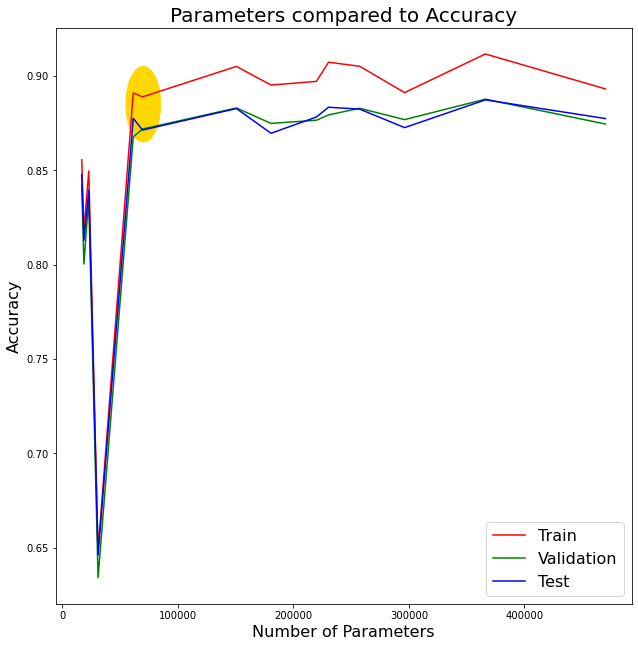

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Create the figure and line plot as before
plt.figure(figsize=(10, 10))
sns.lineplot(x="number of paramaters", y="Train Accuracy", data=summrise_results, color="r")
sns.lineplot(x="number of paramaters", y="Validation Accuracy", data=summrise_results, color="g")
sns.lineplot(x="number of paramaters", y="Test Accuracy", data=summrise_results, color="b")

# Add the oval on top of the line plot
ellipse = Ellipse(xy=(70000, 0.885), width=30000, height=0.04, color='gold')
plt.gca().add_patch(ellipse)

# Add title, axis labels, and legend as before
plt.title("Parameters compared to Accuracy", fontsize=20)
plt.xlabel("Number of Parameters", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.legend(labels=["Train","Validation", "Test"], fontsize=16)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.5, wspace=0.5)


As we can see above, the more parameters we are using the higher the accuracy we get.
It is also seems that until 70,000 parameters there is a big spike in the accuracy, but than the accuracy fets flatten.

One thing I learned from this experience is that adding more parameters to the model seems to improve the train accuracy, but the validation and test accuracy tend to flatten out after around 70,000 parameters. This suggests that training the model beyond this point may not lead to significant improvements in accuracy and may result in overfitting. In future experiments, it might be worthwhile to stop training the model when the validation accuracy starts to flatten.

An interesting observation is that all three accuracies (train, validation, and test) began to flatten at approximately the same number of parameters. This suggests that there may be some underlying relationship between the train, validation, and test accuracies that is worth exploring further.

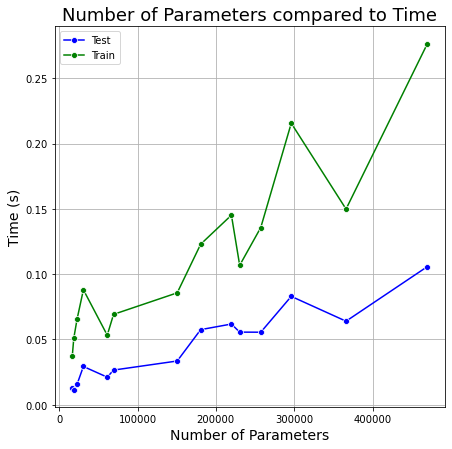

In [29]:
plt.figure(figsize=(7, 7))
sns.lineplot(x="number of paramaters", y="Test time", data = summrise_results, marker = "o", color='b')
sns.lineplot(x="number of paramaters", y="Train time", data = summrise_results, marker = "o", color='g')
plt.title("Number of Parameters compared to Time", fontsize=18)
plt.xlabel("Number of Parameters", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.legend(labels=["Test", "Train", "Validation"])
plt.grid(True)

It is clear that there is a relationship between the number of parameters and the Time of Test and train. is seems like there is a linear correlation. 

In [30]:

index_best_model = np.argmax(np.array(test_accuracy_list))

best_model = models[index_best_model]
total_params_best_model =  sum(p.numel() for p in best_model.parameters())

# We will select the best model based on Accuracy on *Test* Set
print("This model achieved an accuracy of {:.3f} on the test set".format(np.array(test_accuracy_list)[index_best_model]))
print("It was the number {} model in the list of models tested.".format(index_best_model+1))
print("This model had {} layers and a total of {} parameters.".format(num_layers_vec[index_best_model], total_params_best_model))


This model achieved an accuracy of 0.887 on the test set
It was the number 5 model in the list of models tested.
This model had 2 layers and a total of 366210 parameters.


### 3 c.

In [34]:
import pandas as pd
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred, class_names):
    """Displays a confusion matrix for the given true and predicted labels.
    
    Parameters:
    y_true (ndarray): The true labels.
    y_pred (ndarray): The predicted labels.
    class_names (list): A list of class names in the order they appear in the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    cm_df = pd.DataFrame(cm,
                         columns=pd.MultiIndex.from_product([['Prediction'], class_names]),
                         index=pd.MultiIndex.from_product([['Actual'], class_names]))
    
    display(cm_df)

x_test_cm = x_test_fashion_t_normalize
y_test_cm = y_test_fashion_t

_, y_pred_test = best_model(x_test_cm).max(dim=1)

y_true = y_test_cm.detach().numpy()
y_pred = y_pred_test.detach().numpy()

class_names = ['0-T-shirt/top','1-Trouser', '2-Pullover', '3-Dress', '4-Coat', '5-Sandal', '6-Shirt', '7-Sneaker', '8-Bag', '9-Ankle boot']


C:\Users\wings\anaconda3\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [35]:
CM = confusion_matrix(y_true=y_test_cm.detach().numpy(), y_pred=y_pred_test.detach().numpy())

cm_df = pd.DataFrame(CM,
 columns = pd.MultiIndex.from_product([['Prediction'], ['0-T-shirt/top','1-Trouser', '2-Pullover',
                                                        '3-Dress', '4-Coat', '5-Sandal', '6-Shirt',
                                                        '7-Sneaker', '8-Bag', '9-Ankle boot']]),
 index = pd.MultiIndex.from_product([['Actual'], ['0-T-shirt/top','1-Trouser', '2-Pullover',
                                                        '3-Dress', '4-Coat', '5-Sandal', '6-Shirt',
                                                        '7-Sneaker', '8-Bag', '9-Ankle boot']]))

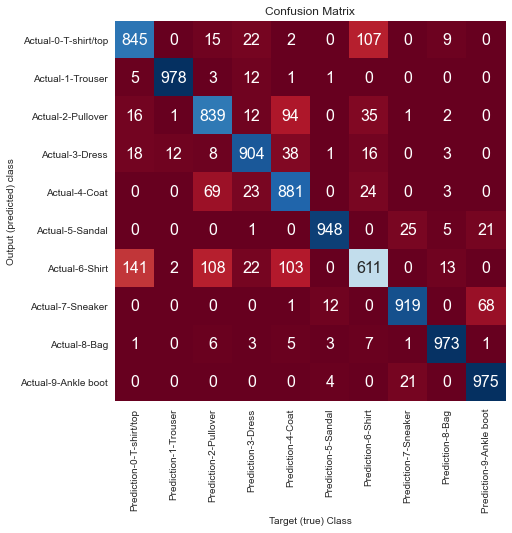

In [36]:
import seaborn as sns

# Set plot style and color map
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("RdBu", n_colors=7))

# Create the plot
plt.subplots(figsize=(7,7))
sns.heatmap(cm_df, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False, cmap="RdBu")
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show()


As we can see, the model performed exceptionally well at predicting trousers, which is not surprising given their distinct appearance from the other categories. On the other hand, the model struggled with predicting shirts. Overall, the model performed very well, as evidenced by the high numbers on the main diagonal of the confusion matrix compared to the other entries.